<a href="https://colab.research.google.com/github/mitsu666/MLaPP/blob/master/MMM_sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pystan
import pandas as pd
import numpy as np
from pandas import DataFrame,Series
import matplotlib.pyplot as plt
from numpy.random import *

In [57]:
from google.colab import files
uploaded = files.upload()

Saving multiTimeline-2.csv to multiTimeline-2 (5).csv


In [0]:
import io
df_t = pd.read_csv(io.StringIO(uploaded['multiTimeline-2.csv'].decode('utf-8')),skiprows=2)

In [53]:
from google.colab import files
uploaded = files.upload()

Saving mmm_sample.csv to mmm_sample (2).csv


In [0]:
df = pd.read_csv(io.StringIO(uploaded['mmm_sample.csv'].decode('utf-8')))

In [60]:
#dmyデータ作成
df_t['週'] = pd.to_datetime(df_t['週'])
df_t['month'] = df_t['週'].apply(lambda x :x.month)
df_t = df_t.groupby('month')['ビール: (日本)'].mean().to_frame()

df['Date'] = pd.to_datetime(df["Date"])
df['month'] = df['Date'].apply(lambda x :x.month)

l = []
for i,j in zip(np.arange(12),df_t.values):
    print (i+1,j[0])
    temp = df[df['month']==(i+1)]
    mu = [25*j[0],10*j[0]]
    sigma = [[10000,300],[300,1500]]
    values = multivariate_normal(mu, sigma, len(temp))
    temp['TV'] = values[:,0]
    temp['NP'] = values[:,1]
    l.append(temp)
    #temp = pd.concat([temp,DataFrame(values)],axis=1)
    #temp

1 48.54545454545455
2 51.45


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


3 55.63636363636363
4 65.81818181818181
5 75.0
6 73.47619047619048
7 77.73913043478261
8 71.47619047619048
9 65.76190476190476
10 57.31818181818182
11 51.81818181818182
12 52.68181818181818


In [0]:
df = pd.concat(l)
df = df.set_index('Date')
df['TV'] = df['TV'].apply(lambda x:0 if x<1100 else x)
df['NP'] = df['NP'].apply(lambda x:0 if x<500 else x)
df = pd.concat([df,df.shift(1)['TV'],df.shift(2)['TV'],df.shift(3)['TV']],axis=1).dropna()
lam = 0.3
df['sales'] = df.apply(lambda x:normal(50*(np.log(1+x[1])+
                              np.log(1+lam*x[3])+np.log(1+lam**(2)*x[4])+np.log(1+lam**(3)*x[5]))+30*np.log(1+x[2])+700,50),axis=1)

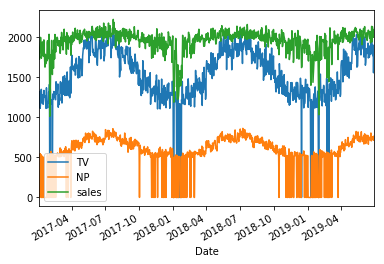

In [62]:
df.columns = ['month', 'TV', 'NP', 'TV_1', 'TV_2', 'TV_3', 'sales']
df[['TV','NP','sales']].plot(kind='line')

In [0]:
X = df[['TV','NP','TV_1','TV_2','TV_3']]
y = df['sales']

In [0]:
model = """
data {
  int<lower=0> N;
  vector[N] TV;
  vector[N] TV_1;
  vector[N] TV_2;
  vector[N] TV_3;
  vector[N] NP;
  vector[N] y;
}
parameters { 
  real beta_0;
  real beta_1;
  real beta_2;
  real<lower=0, upper=1> lambda;
  real<lower=0> sigma;
}

model { 
  for (i in 1:N)
      y[i] ~ normal(beta_0 + beta_1 * (log(TV[i]+1)+log(lambda * TV_1[i]+1)+log(lambda^(2) * TV_2[i]+1)+log(lambda^(3) * TV_3[i]+1)) +log( NP[i]+1)* beta_2 , sigma);
}
"""

In [0]:
dat = {'N':len(X), 'TV': X['TV'].values,'TV_1': X['TV_1'].values,'TV_2': X['TV_2'].values,'TV_3': X['TV_3'].values,'NP': X['NP'].values, 'y': y.values}

In [79]:
fit = pystan.stan(model_code=model, data=dat)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_542e93b340e252b887c39c59a124a725 NOW.


In [80]:
fit

Inference for Stan model: anon_model_542e93b340e252b887c39c59a124a725.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta_0 700.16    0.37   18.9 662.49  687.6 700.01 713.04 736.81   2588    1.0
beta_1  51.09    0.03   1.25  48.57  50.24  51.12  51.94  53.49   2098    1.0
beta_2  28.89    0.02   0.87  27.12  28.29  28.89  29.47  30.56   2980    1.0
lambda   0.28  5.1e-4   0.02   0.24   0.27   0.28    0.3   0.34   2309    1.0
sigma   52.67    0.02   1.24  50.26  51.81  52.67  53.49  55.18   2751    1.0
lp__    -4050    0.04   1.59  -4054  -4051  -4050  -4049  -4048   1718    1.0

Samples were drawn using NUTS at Thu Aug  8 15:30:39 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [76]:
fit

Inference for Stan model: anon_model_15b8daaf44d7d781501bc4cc4f0f4499.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta_0 773.55    0.43  20.94  733.6 759.26 773.24 787.89 815.69   2322    1.0
beta_1  47.03    0.04   1.44  44.27  46.04  47.03  47.97  49.93   1555    1.0
beta_2   0.27  1.8e-4 9.0e-3   0.25   0.26   0.27   0.27   0.28   2391    1.0
lambda   0.31  8.1e-4   0.03   0.25   0.29   0.31   0.33   0.38   1644    1.0
sigma   56.13    0.02    1.3   53.6  55.24  56.09  56.99  58.74   2812    1.0
lp__    -4108    0.04   1.58  -4112  -4108  -4107  -4106  -4106   1817    1.0

Samples were drawn using NUTS at Thu Aug  8 13:52:45 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).